In [1]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tqdm import tqdm
import skimage
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [2]:
def get_mask_data():

    x_train_path = "dataset/Infection/mask_infection.npy"
    x_val_path = "dataset/Infection/mask_infection_val.npy"
    x_test_path = "dataset/Infection/mask_infection_test.npy"
    y_train_path = "dataset/Infection/y_train3.npy"
    y_val_path = "dataset/Infection/y_val3.npy"
    y_test_path = "dataset/Infection/y_test3.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    x_test = np.load(x_test_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)
    y_test = np.load(y_test_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    print(x_test.shape, y_test.shape)
    
        
    return x_train, x_val, x_test, y_train, y_val, y_test


In [23]:
x_train, x_val, x_test, y_train, y_val, y_test = get_mask_data()

(2380, 256, 256, 1) (2380, 256, 256, 1)
(295, 256, 256, 1) (295, 256, 256, 1)
(298, 256, 256, 1) (298, 256, 256, 1)


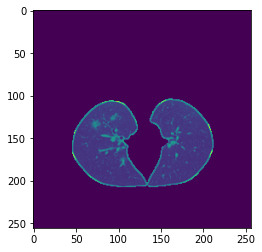

In [21]:
plt.imshow(x_train[5])

In [27]:
print(y_train.max(), y_train.min())

1.0 0.0


In [26]:
y_train[y_train >0] = 1
y_val[y_val > 0] = 1
y_test[y_test > 0] = 1

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [7]:
# max_num = 0
# for i, image in enumerate(x_train) :
#     max_num = np.max(x_train[i])
#     if(np.abs(x_train[i].min()) > max_num) :
#         max_num = np.abs(x_train[i].min())
#     x_train[i] = x_train[i] / max_num
#     if(np.min(x_train[i]) < 0) :
#         x_train[i] = x_train[i] + 1
#         x_train[i] = x_train[i] / 2
#     print('Number : ', i ,' min :', x_train[i].min(),'max : ' ,x_train[i].max())
    
# max_num = 0
# for i, image in enumerate(x_val) :
#     max_num = np.max(x_val[i])
#     if(np.abs(x_val[i].min()) > max_num) :
#         max_num = np.abs(x_val[i].min())
#     x_val[i] = x_val[i] / max_num
#     if(np.min(x_val[i]) < 0) :
#         x_val[i] = x_val[i] + 1
#         x_val[i] = x_val[i] / 2
#     print('Val_Number : ', i ,' min :', x_val[i].min(),'max : ' ,x_val[i].max())

# max_num = 0
# for i, image in enumerate(x_test) :
#     max_num = np.max(x_test[i])
#     if(np.abs(x_test[i].min()) > max_num) :
#         max_num = np.abs(x_test[i].min())
#     x_test[i] = x_test[i] / max_num
#     if(np.min(x_test[i]) < 0) :
#         x_test[i] = x_test[i] + 1
#         x_test[i] = x_test[i] / 2
#     print('Val_Number : ', i ,' min :', x_test[i].min(),'max : ' ,x_test[i].max())

Number :  0  min : 0.0 max :  0.79131895
Number :  1  min : 0.0 max :  0.6875521
Number :  2  min : 0.0 max :  0.7956281
Number :  3  min : 0.0 max :  1.0
Number :  4  min : 0.0 max :  0.84512794
Number :  5  min : 0.0 max :  0.8487457
Number :  6  min : 0.0 max :  0.80265504
Number :  7  min : 0.0 max :  0.8170067
Number :  8  min : 0.0 max :  0.7283621
Number :  9  min : 0.0 max :  1.0
Number :  10  min : 0.0 max :  1.0
Number :  11  min : 0.0 max :  0.8715733
Number :  12  min : 0.0 max :  0.7867391
Number :  13  min : 0.0 max :  0.8289548
Number :  14  min : 0.0 max :  0.891682
Number :  15  min : 0.0 max :  0.71566975
Number :  16  min : 0.0 max :  0.75874174
Number :  17  min : 0.0 max :  1.0
Number :  18  min : 0.0 max :  0.7594558
Number :  19  min : 0.0 max :  1.0
Number :  20  min : 0.0 max :  0.8757059
Number :  21  min : 0.0 max :  0.77244097
Number :  22  min : 0.0 max :  0.8276723
Number :  23  min : 0.0 max :  0.8456292
Number :  24  min : 0.0 max :  0.8638693
Number :  

Number :  247  min : 0.0 max :  0.76749355
Number :  248  min : 0.0 max :  0.7344054
Number :  249  min : 0.0 max :  0.82414097
Number :  250  min : 0.0 max :  1.0
Number :  251  min : 0.0 max :  0.7635622
Number :  252  min : 0.0 max :  0.8161082
Number :  253  min : 0.0 max :  0.8079747
Number :  254  min : 0.0 max :  1.0
Number :  255  min : 0.0 max :  1.0
Number :  256  min : 0.0 max :  0.7153601
Number :  257  min : 0.0 max :  1.0
Number :  258  min : 0.0 max :  1.0
Number :  259  min : 0.0 max :  1.0
Number :  260  min : 0.0 max :  0.78485036
Number :  261  min : 0.0 max :  1.0
Number :  262  min : 0.0 max :  0.7463162
Number :  263  min : 0.0 max :  0.76757705
Number :  264  min : 0.0 max :  1.0
Number :  265  min : 0.0 max :  0.7444546
Number :  266  min : 0.0 max :  1.0
Number :  267  min : 0.0 max :  0.79852045
Number :  268  min : 0.0 max :  1.0
Number :  269  min : 0.0 max :  0.86715275
Number :  270  min : 0.0 max :  1.0
Number :  271  min : 0.0 max :  0.8113512
Number :  

Number :  518  min : 0.0 max :  0.91067153
Number :  519  min : 0.0 max :  1.0
Number :  520  min : 0.0 max :  1.0
Number :  521  min : 0.0 max :  0.8477457
Number :  522  min : 0.0 max :  0.8026886
Number :  523  min : 0.0 max :  1.0
Number :  524  min : 0.0 max :  0.8411759
Number :  525  min : 0.0 max :  0.8462566
Number :  526  min : 0.0 max :  0.8418172
Number :  527  min : 0.0 max :  0.8923257
Number :  528  min : 0.0 max :  0.75045335
Number :  529  min : 0.0 max :  1.0
Number :  530  min : 0.0 max :  0.8657949
Number :  531  min : 0.0 max :  0.817749
Number :  532  min : 0.0 max :  0.8586726
Number :  533  min : 0.0 max :  0.73196787
Number :  534  min : 0.0 max :  0.7882871
Number :  535  min : 0.0 max :  0.8544702
Number :  536  min : 0.0 max :  0.8445899
Number :  537  min : 0.0 max :  0.8063492
Number :  538  min : 0.0 max :  0.78925717
Number :  539  min : 0.0 max :  0.7991479
Number :  540  min : 0.0 max :  1.0
Number :  541  min : 0.0 max :  0.7357813
Number :  542  min 

Number :  735  min : 0.0 max :  0.81497574
Number :  736  min : 0.0 max :  0.7118341
Number :  737  min : 0.0 max :  0.8486246
Number :  738  min : 0.0 max :  0.76708233
Number :  739  min : 0.0 max :  0.72021556
Number :  740  min : 0.0 max :  0.85576624
Number :  741  min : 0.0 max :  0.8105809
Number :  742  min : 0.0 max :  1.0
Number :  743  min : 0.0 max :  0.7842572
Number :  744  min : 0.0 max :  1.0
Number :  745  min : 0.0 max :  0.78551877
Number :  746  min : 0.0 max :  0.8516667
Number :  747  min : 0.0 max :  1.0
Number :  748  min : 0.0 max :  0.8052504
Number :  749  min : 0.0 max :  0.84687644
Number :  750  min : 0.0 max :  0.86131036
Number :  751  min : 0.0 max :  1.0
Number :  752  min : 0.0 max :  0.7757541
Number :  753  min : 0.0 max :  0.83077073
Number :  754  min : 0.0 max :  0.7964076
Number :  755  min : 0.0 max :  0.78126025
Number :  756  min : 0.0 max :  1.0
Number :  757  min : 0.0 max :  0.7749913
Number :  758  min : 0.0 max :  0.77828455
Number :  75

Number :  1022  min : 0.0 max :  0.75539494
Number :  1023  min : 0.0 max :  0.76562464
Number :  1024  min : 0.0 max :  1.0
Number :  1025  min : 0.0 max :  0.77530134
Number :  1026  min : 0.0 max :  1.0
Number :  1027  min : 0.0 max :  0.7332292
Number :  1028  min : 0.0 max :  1.0
Number :  1029  min : 0.0 max :  1.0
Number :  1030  min : 0.0 max :  0.81764966
Number :  1031  min : 0.0 max :  0.8269426
Number :  1032  min : 0.0 max :  0.7291435
Number :  1033  min : 0.0 max :  0.7909943
Number :  1034  min : 0.0 max :  1.0
Number :  1035  min : 0.0 max :  0.7424682
Number :  1036  min : 0.0 max :  0.8241799
Number :  1037  min : 0.0 max :  0.81837595
Number :  1038  min : 0.0 max :  0.86081964
Number :  1039  min : 0.0 max :  1.0
Number :  1040  min : 0.0 max :  0.82787997
Number :  1041  min : 0.0 max :  0.77532244
Number :  1042  min : 0.0 max :  0.81409615
Number :  1043  min : 0.0 max :  0.7783402
Number :  1044  min : 0.0 max :  0.82485384
Number :  1045  min : 0.0 max :  0.80

Number :  1238  min : 0.0 max :  1.0
Number :  1239  min : 0.0 max :  0.76309264
Number :  1240  min : 0.0 max :  0.7412752
Number :  1241  min : 0.0 max :  0.8648318
Number :  1242  min : 0.0 max :  1.0
Number :  1243  min : 0.0 max :  0.8385838
Number :  1244  min : 0.0 max :  0.8099634
Number :  1245  min : 0.0 max :  1.0
Number :  1246  min : 0.0 max :  0.7827066
Number :  1247  min : 0.0 max :  1.0
Number :  1248  min : 0.0 max :  1.0
Number :  1249  min : 0.0 max :  0.6882459
Number :  1250  min : 0.0 max :  0.83780795
Number :  1251  min : 0.0 max :  0.8675995
Number :  1252  min : 0.0 max :  1.0
Number :  1253  min : 0.0 max :  1.0
Number :  1254  min : 0.0 max :  0.76785904
Number :  1255  min : 0.0 max :  1.0
Number :  1256  min : 0.0 max :  0.8350183
Number :  1257  min : 0.0 max :  1.0
Number :  1258  min : 0.0 max :  0.7588609
Number :  1259  min : 0.0 max :  0.81868804
Number :  1260  min : 0.0 max :  1.0
Number :  1261  min : 0.0 max :  0.88692796
Number :  1262  min : 0

Number :  1443  min : 0.0 max :  1.0
Number :  1444  min : 0.0 max :  0.7161022
Number :  1445  min : 0.0 max :  1.0
Number :  1446  min : 0.0 max :  1.0
Number :  1447  min : 0.0 max :  0.69457376
Number :  1448  min : 0.0 max :  0.7569684
Number :  1449  min : 0.0 max :  0.83236015
Number :  1450  min : 0.0 max :  0.746242
Number :  1451  min : 0.0 max :  0.7790557
Number :  1452  min : 0.0 max :  0.88453734
Number :  1453  min : 0.0 max :  0.7421896
Number :  1454  min : 0.0 max :  0.8161742
Number :  1455  min : 0.0 max :  0.73192805
Number :  1456  min : 0.0 max :  0.7457988
Number :  1457  min : 0.0 max :  1.0
Number :  1458  min : 0.0 max :  1.0
Number :  1459  min : 0.0 max :  0.83655316
Number :  1460  min : 0.0 max :  0.85518736
Number :  1461  min : 0.0 max :  0.8128195
Number :  1462  min : 0.0 max :  0.75455016
Number :  1463  min : 0.0 max :  1.0
Number :  1464  min : 0.0 max :  0.7112887
Number :  1465  min : 0.0 max :  0.7968354
Number :  1466  min : 0.0 max :  0.759562

Number :  1694  min : 0.0 max :  0.7532527
Number :  1695  min : 0.0 max :  0.8500348
Number :  1696  min : 0.0 max :  0.7997991
Number :  1697  min : 0.0 max :  0.8446678
Number :  1698  min : 0.0 max :  0.8719512
Number :  1699  min : 0.0 max :  0.78095603
Number :  1700  min : 0.0 max :  1.0
Number :  1701  min : 0.0 max :  0.77391857
Number :  1702  min : 0.0 max :  0.76768494
Number :  1703  min : 0.0 max :  0.8409018
Number :  1704  min : 0.0 max :  1.0
Number :  1705  min : 0.0 max :  0.7910768
Number :  1706  min : 0.0 max :  0.7951138
Number :  1707  min : 0.0 max :  0.78456384
Number :  1708  min : 0.0 max :  0.82017875
Number :  1709  min : 0.0 max :  0.7736889
Number :  1710  min : 0.0 max :  0.80580544
Number :  1711  min : 0.0 max :  0.77484035
Number :  1712  min : 0.0 max :  0.820622
Number :  1713  min : 0.0 max :  0.76498413
Number :  1714  min : 0.0 max :  1.0
Number :  1715  min : 0.0 max :  0.8264255
Number :  1716  min : 0.0 max :  1.0
Number :  1717  min : 0.0 ma

Number :  1927  min : 0.0 max :  0.7810389
Number :  1928  min : 0.0 max :  1.0
Number :  1929  min : 0.0 max :  0.7195276
Number :  1930  min : 0.0 max :  0.76831955
Number :  1931  min : 0.0 max :  1.0
Number :  1932  min : 0.0 max :  0.8352258
Number :  1933  min : 0.0 max :  0.83037347
Number :  1934  min : 0.0 max :  0.8169446
Number :  1935  min : 0.0 max :  1.0
Number :  1936  min : 0.0 max :  1.0
Number :  1937  min : 0.0 max :  0.80337405
Number :  1938  min : 0.0 max :  0.7567159
Number :  1939  min : 0.0 max :  1.0
Number :  1940  min : 0.0 max :  0.8592588
Number :  1941  min : 0.0 max :  0.84008497
Number :  1942  min : 0.0 max :  0.8453139
Number :  1943  min : 0.0 max :  1.0
Number :  1944  min : 0.0 max :  0.8420934
Number :  1945  min : 0.0 max :  0.81219727
Number :  1946  min : 0.0 max :  0.75313795
Number :  1947  min : 0.0 max :  0.76735824
Number :  1948  min : 0.0 max :  0.81464356
Number :  1949  min : 0.0 max :  0.7755807
Number :  1950  min : 0.0 max :  1.0
Nu

Number :  2170  min : 0.0 max :  0.86515874
Number :  2171  min : 0.0 max :  0.8252194
Number :  2172  min : 0.0 max :  0.7155484
Number :  2173  min : 0.0 max :  0.7841883
Number :  2174  min : 0.0 max :  0.75065136
Number :  2175  min : 0.0 max :  0.8381114
Number :  2176  min : 0.0 max :  1.0
Number :  2177  min : 0.0 max :  1.0
Number :  2178  min : 0.0 max :  0.7230309
Number :  2179  min : 0.0 max :  0.7506869
Number :  2180  min : 0.0 max :  0.7933884
Number :  2181  min : 0.0 max :  0.86066103
Number :  2182  min : 0.0 max :  0.8351593
Number :  2183  min : 0.0 max :  0.8798163
Number :  2184  min : 0.0 max :  0.8334098
Number :  2185  min : 0.0 max :  0.8217161
Number :  2186  min : 0.0 max :  0.777914
Number :  2187  min : 0.0 max :  0.74260914
Number :  2188  min : 0.0 max :  0.77095103
Number :  2189  min : 0.0 max :  0.82025576
Number :  2190  min : 0.0 max :  0.87749636
Number :  2191  min : 0.0 max :  0.8683218
Number :  2192  min : 0.0 max :  1.0
Number :  2193  min : 0

Val_Number :  91  min : 0.0 max :  1.0
Val_Number :  92  min : 0.0 max :  0.8559078
Val_Number :  93  min : 0.0 max :  0.8086706
Val_Number :  94  min : 0.0 max :  1.0
Val_Number :  95  min : 0.0 max :  1.0
Val_Number :  96  min : 0.0 max :  0.8181088
Val_Number :  97  min : 0.0 max :  0.8266897
Val_Number :  98  min : 0.0 max :  1.0
Val_Number :  99  min : 0.0 max :  0.7954664
Val_Number :  100  min : 0.0 max :  1.0
Val_Number :  101  min : 0.0 max :  0.7686264
Val_Number :  102  min : 0.0 max :  1.0
Val_Number :  103  min : 0.0 max :  1.0
Val_Number :  104  min : 0.0 max :  0.7879797
Val_Number :  105  min : 0.0 max :  0.76439476
Val_Number :  106  min : 0.0 max :  1.0
Val_Number :  107  min : 0.0 max :  0.7043846
Val_Number :  108  min : 0.0 max :  1.0
Val_Number :  109  min : 0.0 max :  0.8676045
Val_Number :  110  min : 0.0 max :  0.8195688
Val_Number :  111  min : 0.0 max :  0.7789574
Val_Number :  112  min : 0.0 max :  0.7773932
Val_Number :  113  min : 0.0 max :  0.75011194
Val

Val_Number :  42  min : 0.0 max :  0.7606685
Val_Number :  43  min : 0.0 max :  0.8210238
Val_Number :  44  min : 0.0 max :  1.0
Val_Number :  45  min : 0.0 max :  0.87958616
Val_Number :  46  min : 0.0 max :  0.8493171
Val_Number :  47  min : 0.0 max :  1.0
Val_Number :  48  min : 0.0 max :  1.0
Val_Number :  49  min : 0.0 max :  0.7791238
Val_Number :  50  min : 0.0 max :  0.7702979
Val_Number :  51  min : 0.0 max :  0.71451044
Val_Number :  52  min : 0.0 max :  0.8639198
Val_Number :  53  min : 0.0 max :  1.0
Val_Number :  54  min : 0.0 max :  0.7527007
Val_Number :  55  min : 0.0 max :  0.69962275
Val_Number :  56  min : 0.0 max :  0.80265725
Val_Number :  57  min : 0.0 max :  0.8028596
Val_Number :  58  min : 0.0 max :  0.83548737
Val_Number :  59  min : 0.0 max :  0.7971021
Val_Number :  60  min : 0.0 max :  1.0
Val_Number :  61  min : 0.0 max :  0.79813236
Val_Number :  62  min : 0.0 max :  0.8193555
Val_Number :  63  min : 0.0 max :  1.0
Val_Number :  64  min : 0.0 max :  0.754

Val_Number :  288  min : 0.0 max :  1.0
Val_Number :  289  min : 0.0 max :  0.843869
Val_Number :  290  min : 0.0 max :  0.7851447
Val_Number :  291  min : 0.0 max :  0.8226751
Val_Number :  292  min : 0.0 max :  0.7699774
Val_Number :  293  min : 0.0 max :  1.0
Val_Number :  294  min : 0.0 max :  1.0
Val_Number :  295  min : 0.15481809 max :  1.0
Val_Number :  296  min : 0.16498688 max :  1.0
Val_Number :  297  min : 0.13691401 max :  1.0


In [28]:
print(y_train.shape, y_val.shape)
print(y_train.dtype)
y_train2 = np.zeros((2380, 256, 256, 2), dtype=np.uint8)
y_val2 = np.zeros((295, 256, 256, 2), dtype=np.uint8)
y_test2 = np.zeros((298, 256, 256, 2), dtype=np.uint8)

y_train2[..., 0] = y_train[..., 0]
y_train2[..., 1] = 1 - y_train[..., 0]
y_val2[..., 0] = y_val[..., 0]
y_val2[..., 1] = 1-y_val[..., 0]
y_test2[..., 0] = y_test[..., 0]
y_test2[..., 1] = 1-y_test[..., 0]

(2380, 256, 256, 1) (295, 256, 256, 1)
float32


In [10]:
# print(x_train.max(), x_train.min())

1.0 0.0


In [29]:
np.save("dataset/Infection/y_train3.npy", y_train2)
np.save("dataset/Infection/y_val3.npy",y_val2)
np.save("dataset/Infection/y_test3.npy", y_test2)

In [3]:
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.MeanIoU(num_classes=3)])

    model.summary()
    
    
    

    return model

In [4]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')

#     predic = model.predict(x_val)

#     fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
#     temp = np.empty((256, 256, 1), dtype=np.float32)

#     for i in range(40):
#         ax[i, 0].imshow(x_val[i].squeeze(), cmap='hot')
#         ax[i, 0].title.set_text(str(i))
#         ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
#         ax[i, 2].imshow(predic[i].squeeze(), cmap='gray')
        
        
#         temp = x_val[i]
#         pred_sum = predic[i][predic[i] > 0]
#         pred_mean = np.mean(pred_sum)
#         if(np.min(x_val[i]) >= 0) :
#             predic[i] = (predic[i]/ np.max(predic[i])) * 255
#             temp = cv2.add(temp, predic[i])
#         else :
#             predic[i] = (predic[i]/ np.max(predic[i])) * 2048
#             temp = cv2.add(temp, predic[i])
#         ax[i, 3].imshow(temp.squeeze(), cmap='Reds')
# #         temp = x_val[i]
# #         pred_sum = preds[i][preds[i] > 0]
# #         pred_mean = np.mean(pred_sum)
# #         if(np.min(temp) >= 0) :
# #             temp[preds[i] < pred_mean] = 0
# #         else :
# #             temp[preds[i] < pred_mean] = -2048
# #         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


(2380, 256, 256, 1) (2380, 256, 256, 2)
(295, 256, 256, 1) (295, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d_1[0][

Epoch 1/30
149/149 [==============================] - 88s 514ms/step - loss: 0.4890 - acc: 0.9589 - mean_io_u: 0.2507 - val_loss: 0.3488 - val_acc: 0.9852 - val_mean_io_u: 0.2500
Epoch 2/30
149/149 [==============================] - 70s 468ms/step - loss: 0.1702 - acc: 0.9909 - mean_io_u: 0.2520 - val_loss: 0.1250 - val_acc: 0.9852 - val_mean_io_u: 0.2500
Epoch 3/30
149/149 [==============================] - 70s 468ms/step - loss: 0.0562 - acc: 0.9910 - mean_io_u: 0.2517 - val_loss: 0.0714 - val_acc: 0.9852 - val_mean_io_u: 0.2500
Epoch 4/30
149/149 [==============================] - 70s 467ms/step - loss: 0.0304 - acc: 0.9918 - mean_io_u: 0.2514 - val_loss: 0.0421 - val_acc: 0.9882 - val_mean_io_u: 0.2504
Epoch 5/30
149/149 [==============================] - 70s 467ms/step - loss: 0.0223 - acc: 0.9928 - mean_io_u: 0.2510 - val_loss: 0.0668 - val_acc: 0.9856 - val_mean_io_u: 0.2500
Epoch 6/30
149/149 [==============================] - 69s 466ms/step - loss: 0.0195 - acc: 0.9934 - mean_

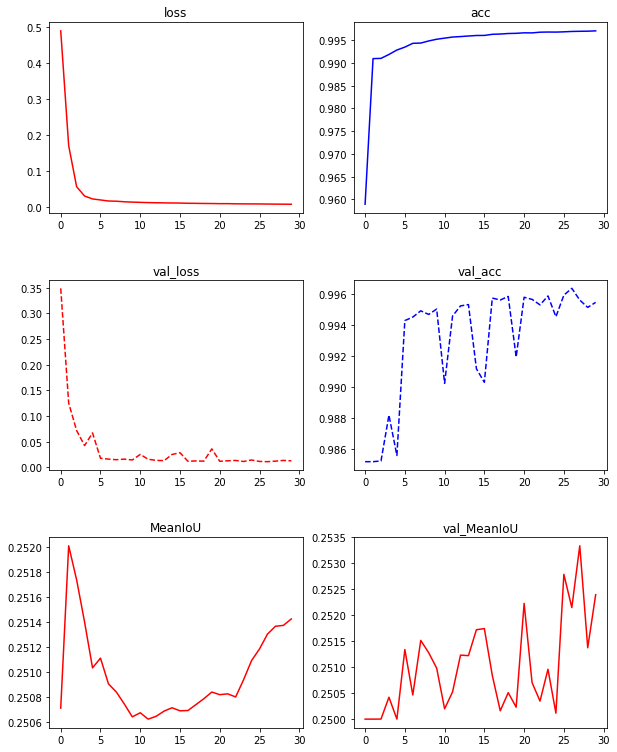

In [5]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
model = VGG16_Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

(2380, 256, 256, 1)
(2, 256, 256, 1)


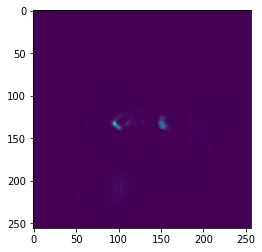

(2380, 256, 256, 1) (2380, 256, 256, 2)
(295, 256, 256, 1) (295, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)


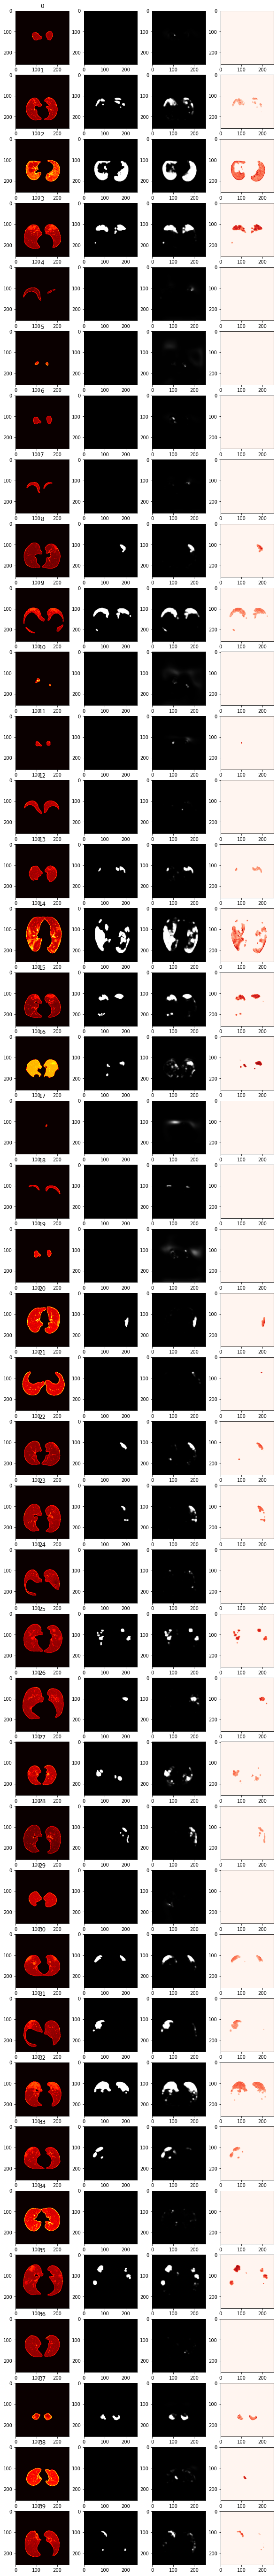

In [6]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
predic = model.predict(x_val)

fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

y = y_val[...,0]
predic_0 = predic[...,0]
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='hot')
    ax[i, 0].title.set_text(str(i))
    ax[i, 1].imshow(y[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(predic_0[i].squeeze(), cmap='gray')
        
        
    temp = x_val[i]
    temp[predic_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='Reds')

In [7]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = predic[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output index번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if y_label_image[i][j] == 1 or predict_image[i][j] == 1:
                if y_label_image[i][j] == 1 and predict_image[i][j] == 1:
                    TP = TP + 1
                else :
                    NP = NP + 1
            
    if TP == 0 and NP == 0 : 
        TP = 1
    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image + 1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 1 NP :  0
IOU : 1.0 

Number :  1 TP : 1080 NP :  894
IOU : 0.547112462006079 

Number :  2 TP : 6334 NP :  1053
IOU : 0.8574522810342493 

Number :  3 TP : 2360 NP :  380
IOU : 0.8613138686131386 

Number :  4 TP : 1 NP :  0
IOU : 1.0 

Number :  5 TP : 1 NP :  0
IOU : 1.0 

Number :  6 TP : 1 NP :  0
IOU : 1.0 

Number :  7 TP : 1 NP :  0
IOU : 1.0 

Number :  8 TP : 526 NP :  111
IOU : 0.82574568288854 

Number :  9 TP : 3008 NP :  580
IOU : 0.8383500557413601 

Number :  10 TP : 1 NP :  0
IOU : 1.0 

Number :  11 TP : 0 NP :  35
IOU : 0.0 

Number :  12 TP : 1 NP :  0
IOU : 1.0 

Number :  13 TP : 714 NP :  154
IOU : 0.8225806451612904 

Number :  14 TP : 6853 NP :  2494
IOU : 0.7331764202417889 

Number :  15 TP : 1664 NP :  403
IOU : 0.8050314465408805 

Number :  16 TP : 441 NP :  561
IOU : 0.44011976047904194 

Number :  17 TP : 1 NP :  0
IOU : 1.0 

Number :  18 TP : 1 NP :  0
IOU : 1.0 

Number :  19 TP : 1 NP :  0
IOU : 1.0 

Number :  20 TP : 489 NP :  89
I

Number :  157 TP : 2881 NP :  2144
IOU : 0.5733333333333334 

Number :  158 TP : 2252 NP :  468
IOU : 0.8279411764705882 

Number :  159 TP : 1 NP :  0
IOU : 1.0 

Number :  160 TP : 0 NP :  5
IOU : 0.0 

Number :  161 TP : 437 NP :  150
IOU : 0.7444633730834753 

Number :  162 TP : 1 NP :  0
IOU : 1.0 

Number :  163 TP : 1053 NP :  233
IOU : 0.8188180404354588 

Number :  164 TP : 0 NP :  35
IOU : 0.0 

Number :  165 TP : 2306 NP :  1201
IOU : 0.6575420587396635 

Number :  166 TP : 1705 NP :  270
IOU : 0.8632911392405064 

Number :  167 TP : 277 NP :  191
IOU : 0.5918803418803419 

Number :  168 TP : 628 NP :  297
IOU : 0.6789189189189189 

Number :  169 TP : 1 NP :  0
IOU : 1.0 

Number :  170 TP : 1165 NP :  233
IOU : 0.8333333333333334 

Number :  171 TP : 1 NP :  0
IOU : 1.0 

Number :  172 TP : 1 NP :  0
IOU : 1.0 

Number :  173 TP : 1 NP :  0
IOU : 1.0 

Number :  174 TP : 1434 NP :  1037
IOU : 0.5803318494536625 

Number :  175 TP : 211 NP :  499
IOU : 0.2971830985915493 

N

In [ ]:
def get_predict_part(original ,predict) :
    copy_original = original.copy()
    
    for i, pred in enumerate(predict):
        if(np.min(copy_original[i]) >= 0) :
            pred = (pred/ np.max(pred)) * 255
            copy_original[i] = cv2.add(copy_original[i], pred)
        else :
            pred = (pred/ np.max(pred)) * 2048
            copy_original[i] = cv2.add(copy_original[i], pred)
            
    return copy_original

In [ ]:
all_data_path= "transe"
original_data_path = "transe/data"
answer_data_path = "transe/transe"

data_set_folder_list = os.listdir(original_data_path)

for i, folder_name in enumerate(data_set_folder_list):
    address  = original_data_path + '/' + folder_name
    folder_video_set = os.listdir(address)
    for j, tar_name in enumerate(folder_video_set) :
        tar_address = address + '/' + tar_name
        raw_img = nib.load(tar_address)
        img_array = np.array(raw_img.get_fdata(), dtype=np.float32)
        images = img_array.T
        img_data = np.empty(( len(images), 256, 256, 1), dtype=np.float32)
        for i, image_array in enumerate(images) :
            img = resize(image_array, output_shape=(256, 256, 1), preserve_range=True)
            img_data[i] = img
        pres = model.predict(img_data)
        
        predict_lung = get_predict_part(img_data ,pres)
        
        
        
        save_address = answer_data_path + "/" + folder_name + "/" + tar_name
        np.save(save_address, predict_lung)



In [ ]:
def get_data() :
    x_test_path = "dataset/Infection/mask_infection_test.npy"
    y_test_path = "dataset/Infection/y_test.npy"
    
    x_test = np.load(x_test_path)
    y_test = np.load(y_test_path)

    print(x_test.shape, y_test.shape)
    
        
    return x_test, y_test

In [ ]:
x_test, y_test = get_data()
predic = model.predict(x_test)


fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)
for i in range(40):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 0].title.set_text(str(i))
    ax[i, 1].imshow(predic[i].squeeze(), cmap='gray')
#     print(i, " : ", np.max(predic[i]))
    ax[i, 2].imshow(y_test[i].squeeze(), cmap='gray')
#     predic[i] = (predic[i]/ np.max(predic[i])) * 255
#     temp = cv2.add(x_test[i], predic[i])
#     temp = x_test[i]
    pred_sum = predic[i][predic[i] > 0]
    pred_mean = np.mean(pred_sum)
    if(np.min(x_test[i]) >= 0) :
#         temp[predic[i] < pred_mean] = 0
        predic[i] = (predic[i]/ np.max(predic[i])) * 255
        temp = cv2.add(x_test[i], predic[i])
    else :
#         temp[predic[i] < pred_mean] = -2048
        predic[i] = (predic[i]/ np.max(predic[i])) * 2048
        temp = cv2.add(x_test[i], predic[i])
    ax[i, 3].imshow(temp.squeeze(), cmap='Reds')



In [ ]:
copy_predict = predic[25].copy()
copy_test = x_test[25].copy()

In [ ]:
copy_test = cv2.add(copy_test,copy_predict)
plt.imshow(copy_test.squeeze(), cmap = 'gray')
copy_predict = (copy_predict/ np.max(copy_predict))
for i in range(10) : 
    copy_predict = copy_predict * 10
    copy_predict = (copy_predict/ np.max(copy_predict))

In [ ]:
img = resize(copy_test, output_shape=(256, 256, 3), preserve_range=True)
img = img / 2048
img = img * 255
img = img + 255
img = img / 2
img = img /255
where = np.where(copy_predict >= 0.4)
for i, x in enumerate(where[0]) :
    img[x][where[1][i]] = (1,0,0)
plt.imshow(img.squeeze())

In [ ]:
img = resize(temp, output_shape=(256, 256, 3), preserve_range=True)
img = img / 2048
img = img * 255
img = img + 255
img = img / 2
img = img /255
# for x in range(80,100) :
#     for y in range(80,120) :
#         img[x,y] = (1,0,0)
plt.imshow(img.squeeze())
np.save("sample",img)

In [ ]:
copy_img = np.load("sample.npy")
copy_img = copy_img / np.max(copy_img)
# copy_img[copy_img >= 0.8] = (1,0,0)

where = np.where(copy_img >= 0.9)
print(where[0][1])
for i, x in enumerate(where[0]) :
    copy_img[x][where[1][i]] = (1,0,0)
plt.imshow(copy_img.squeeze())

In [ ]:
print(img[140])

In [ ]:
tesst =resize(predic[39], output_shape=(256, 256, 3), preserve_range=True)
tesst = tesst / 2048
tesst = tesst * 255
tesst = tesst + 255
tesst = tesst / 2
tesst = tesst /255
plt.imshow(tesst)
print(tesst[140])

In [ ]:
tesst= tesst - np.min(tesst)
tesst *2
plt.imshow(tesst)